In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import keras
from keras.models import *
from keras.layers import *
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from keras import backend as K
K.set_session(session)

C:\Users\peter\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATASET_ROOT = './0518'
TRAIN_PATH = os.path.join(DATASET_ROOT, 'taetfp.csv')
TS_IN=8
TS_OUT=5
fields = ['開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)', '成交張數(張)']
fields_dict = dict()
for n, f in enumerate(fields):
    fields_dict[f] = n

,代碼,日期,中文簡稱,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
0,50,20130102,元大台灣50,46.57,47.13,46.49,46.92,16487.0
5268,54,20130102,元大台商50,16.84,16.84,16.54,16.75,20.0
7902,56,20130102,元大高股息,18.45,18.63,18.45,18.55,1623.0
9219,57,20130102,富邦摩台,30.35,30.69,30.35,30.69,69.0
3951,53,20130102,元大電子,19.84,19.84,19.52,19.81,42.0
10536,58,20130102,富邦發達,32.45,32.45,32.12,32.12,2.0
11853,59,20130102,富邦金融,24.65,24.65,24.65,24.65,2.0
2634,52,20130102,富邦科技,26.57,26.95,26.57,26.92,26.0
13170,6201,20130102,元大富櫃50,9.08,9.18,9.01,9.13,254.0
14487,6203,20130102,元大MSCI台灣,22.61,22.61,22.56,22.56,28.0


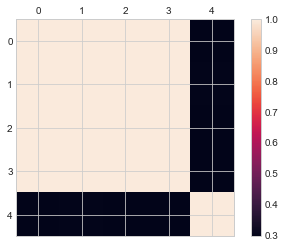

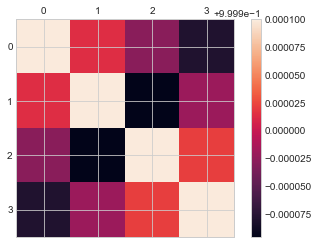

In [3]:
train_csv = pd.read_csv(TRAIN_PATH)
train_csv.sort_values(by=['日期'], ascending=True, inplace=True)
train_csv[fields] = train_csv[fields].applymap(lambda x: float(x.replace(',','')) if type(x)==str else x)
display(train_csv.head(n=10))
fig, ax = plt.subplots()
cax = ax.matshow(train_csv[fields].corr())
fig.colorbar(cax)
plt.show()
fig, ax = plt.subplots()
cax = ax.matshow(train_csv[['開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)']].corr())
fig.colorbar(cax)
plt.show()

In [4]:
codes = list(sorted(set(train_csv['代碼'])))

code 50


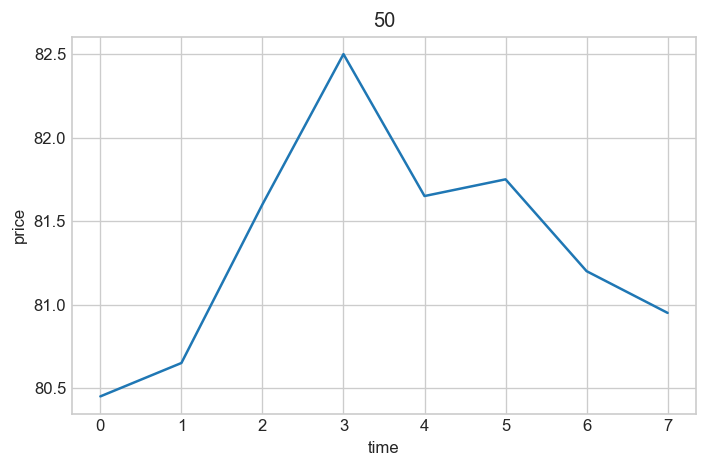

code 51


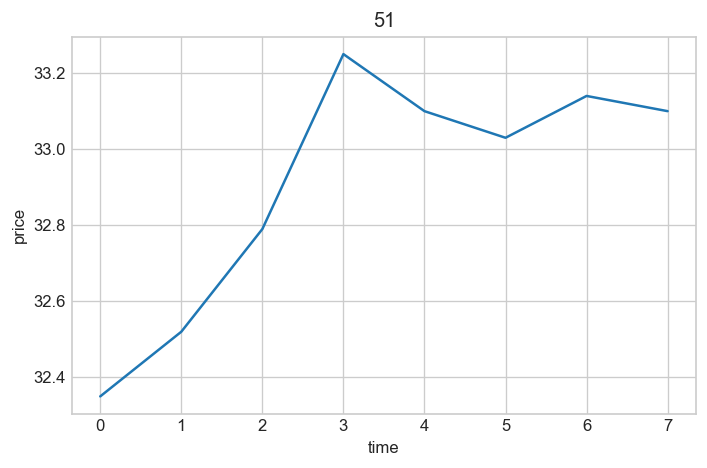

code 52


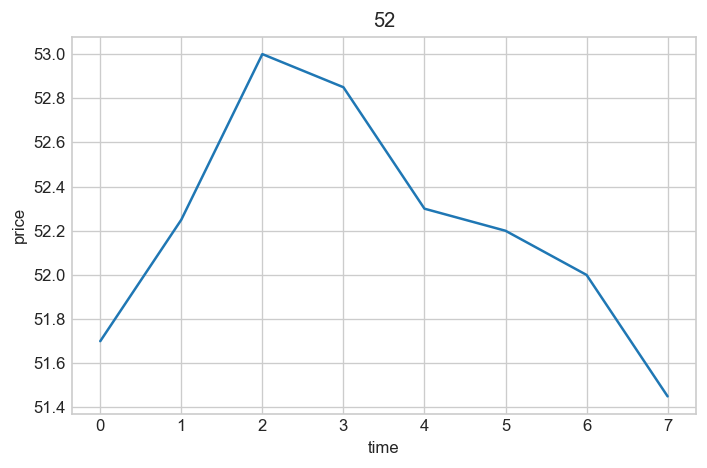

code 53


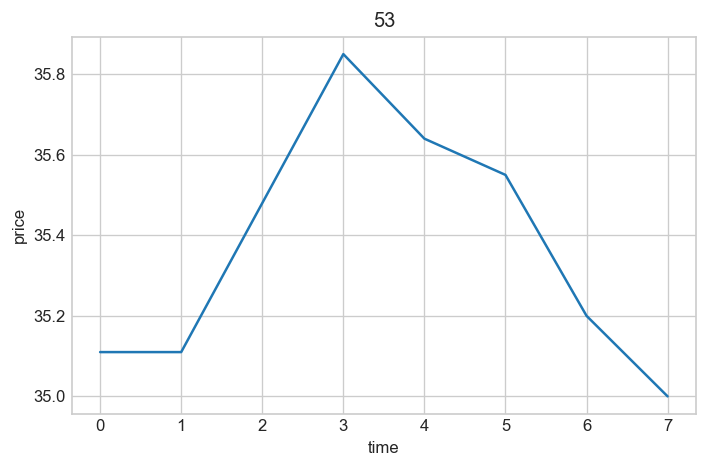

code 54


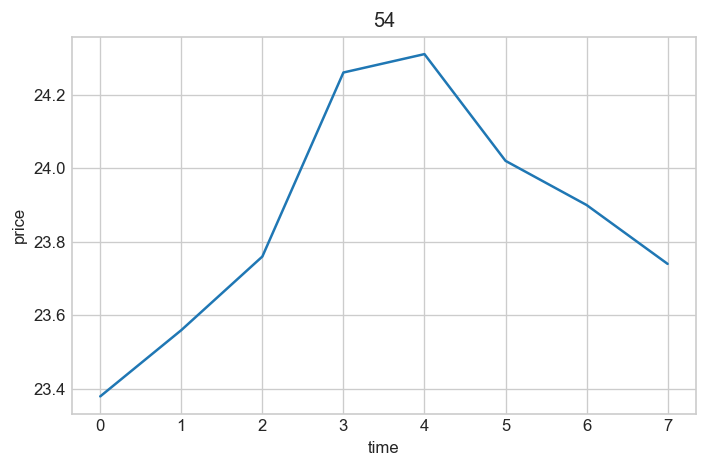

code 55


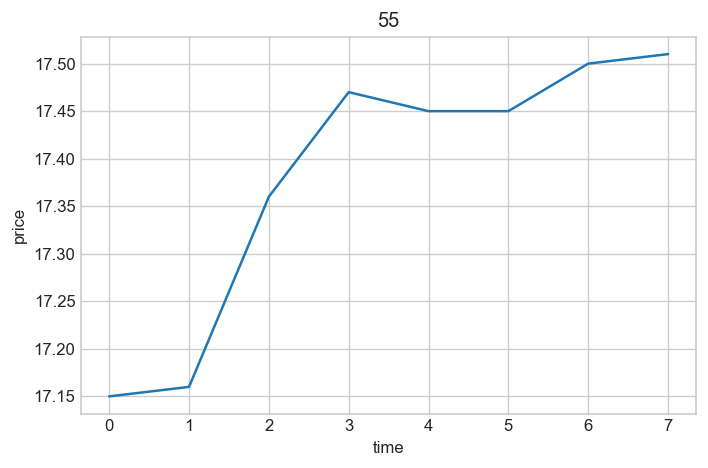

code 56


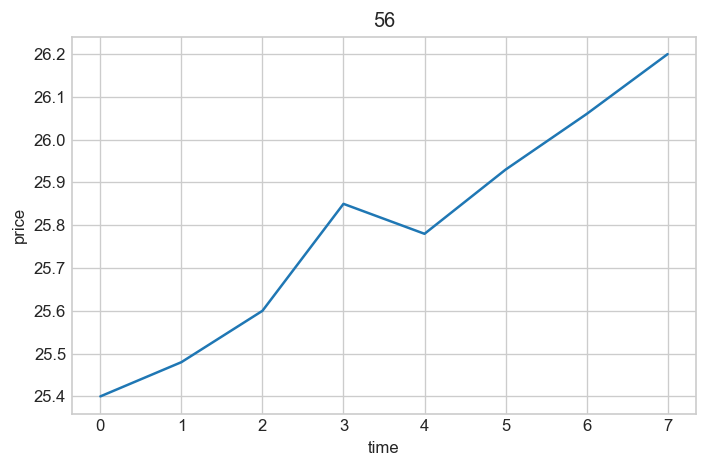

code 57


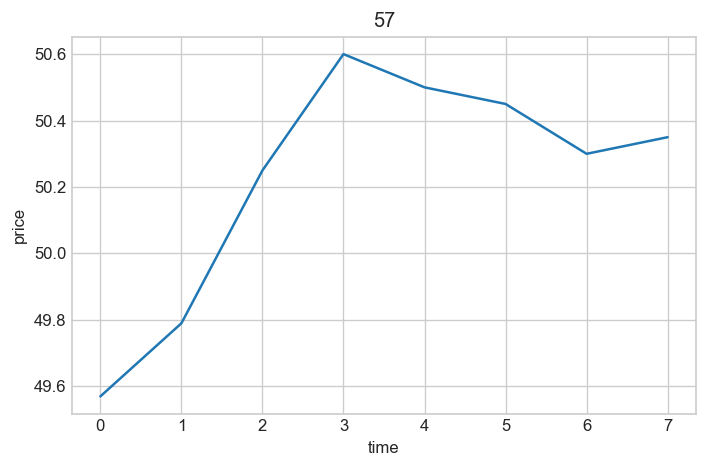

code 58


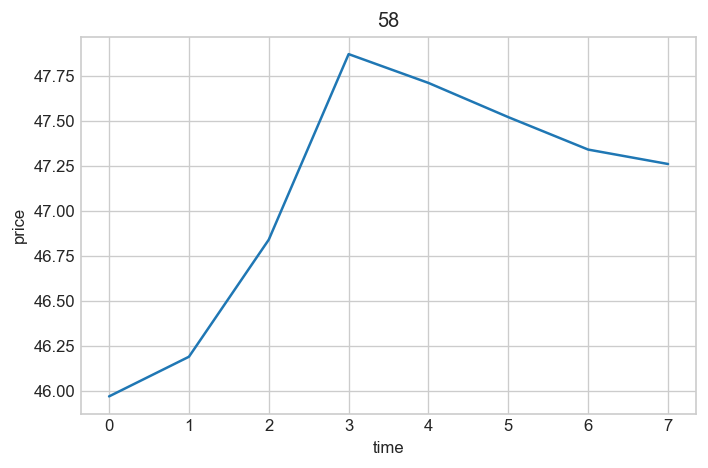

code 59


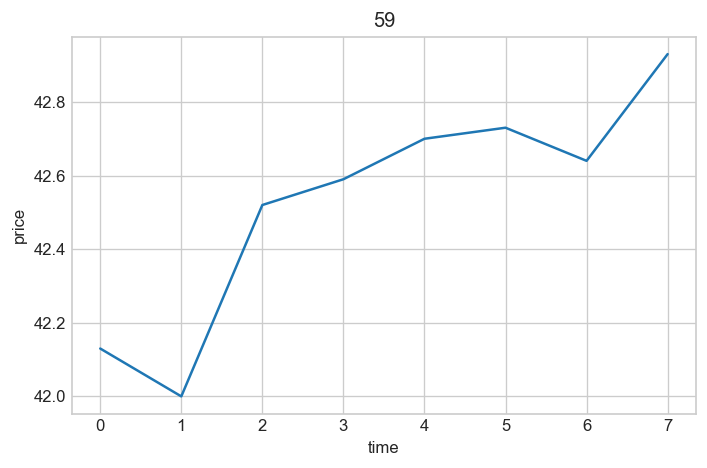

code 690


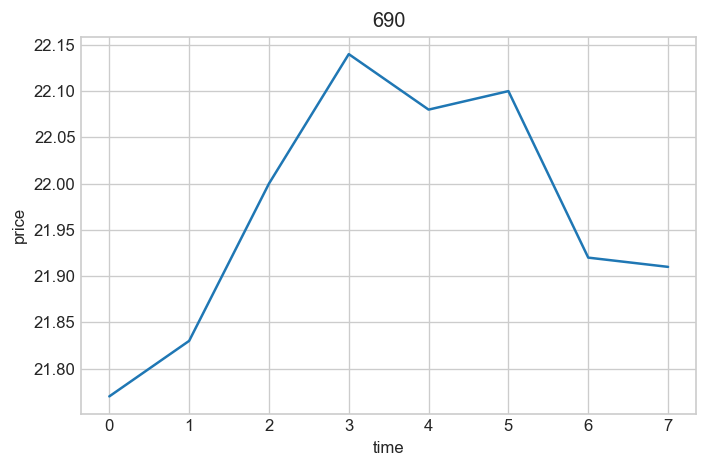

code 692


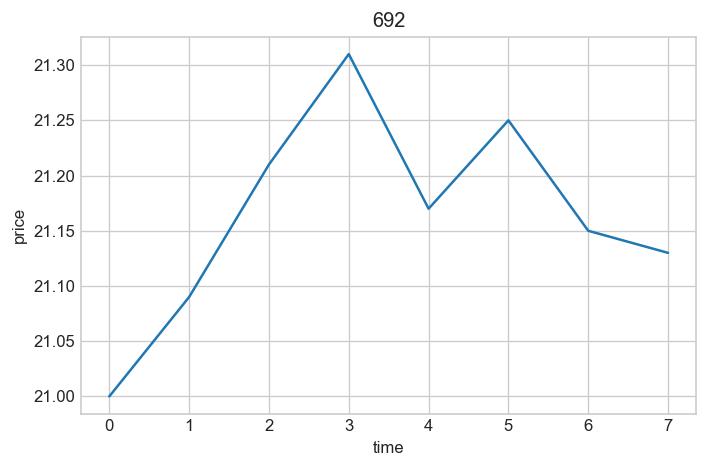

code 701


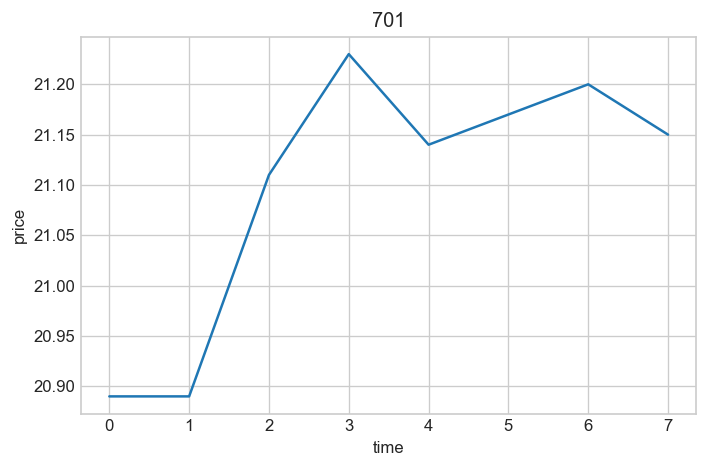

code 713


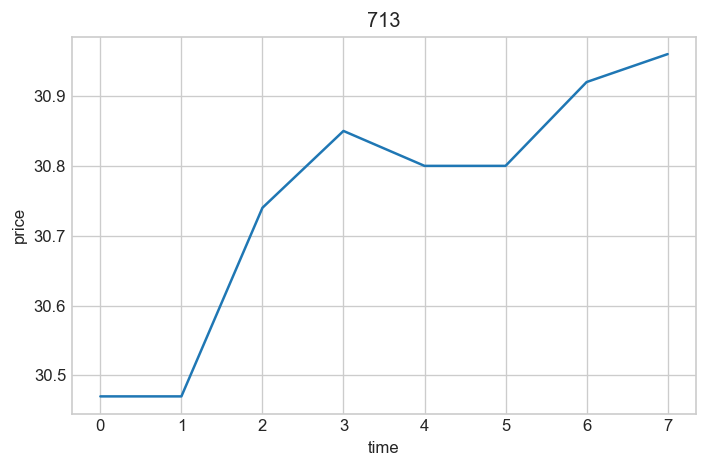

code 6201


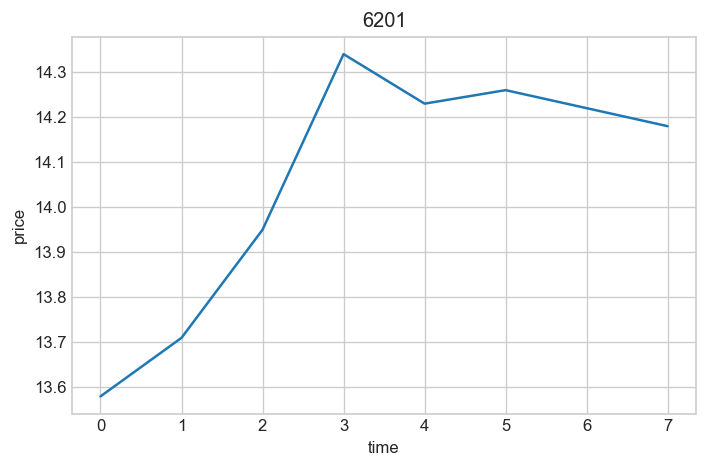

code 6203


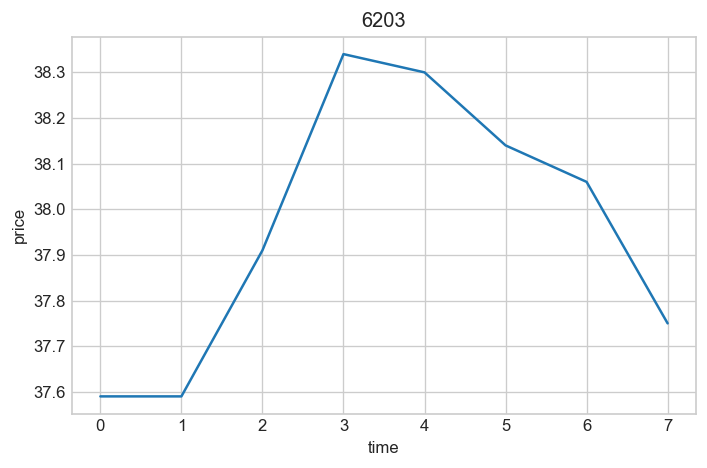

code 6204


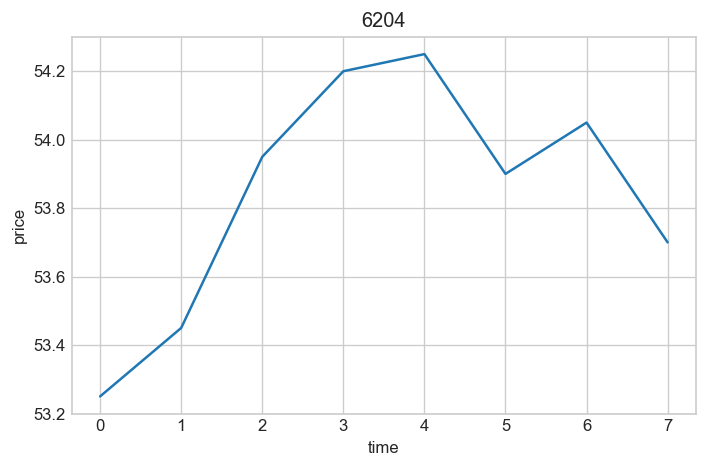

code 6208


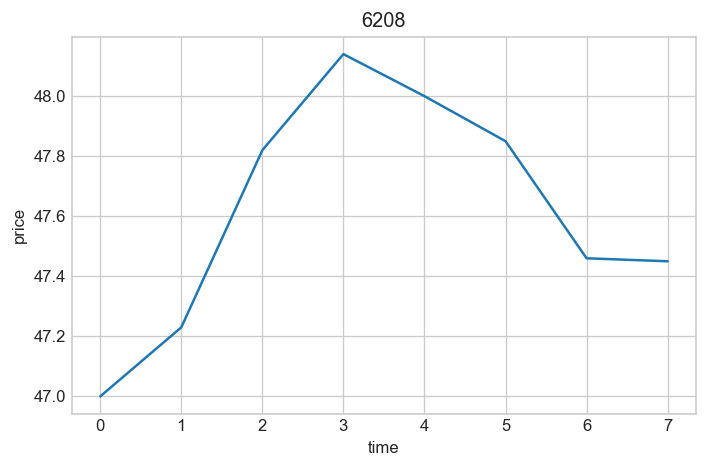

In [5]:
split_train = []
for code in codes:
    row   = np.asarray(train_csv.loc[train_csv['代碼']==code][fields], dtype=np.float32)[-TS_IN-3:]
    label = np.append(np.array([0], dtype=np.float32), (row[1:,-2] > row[:-1,-2]).astype(np.float32)).astype(np.float32)[...,np.newaxis]
    row = np.append(row, label, axis=-1)[-TS_IN:]
    print('code {:d}'.format(code))
    fit, ax = plt.subplots(dpi=120)
    ax.set_title(str(code))
    ax.set_xlabel('time')
    ax.set_ylabel('price')
    ax.plot(range(row.shape[0]), row[...,fields_dict['收盤價(元)']])
    plt.tight_layout()
    plt.show()
    split_train.append(row)

In [6]:
for n, s in enumerate(split_train):
    print(codes[n], len(s))

50 8
51 8
52 8
53 8
54 8
55 8
56 8
57 8
58 8
59 8
690 8
692 8
701 8
713 8
6201 8
6203 8
6204 8
6208 8


In [7]:
from keras.regularizers import l2
def make_model(ts_in=60, ts_out=5, n_field=6, n_encode=128, n_decode=128, reg_a=0.1):
    input_ = Input(shape=(ts_in, n_field))
    lstm_1 = CuDNNLSTM(n_encode, return_sequences=False, recurrent_regularizer=l2(reg_a)) (input_)
    rep_vec_2 = RepeatVector(ts_out) (lstm_1)
    lstm_3 = CuDNNLSTM(n_decode, return_sequences=True, recurrent_regularizer=l2(reg_a)) (rep_vec_2)
    lstm_4 = CuDNNLSTM(n_decode, return_sequences=True, recurrent_regularizer=l2(reg_a)) (lstm_3)
    fc_4_regression     = TimeDistributed(Dense(1, kernel_regularizer=l2(reg_a)), name='regression') (lstm_4)
    fc_4_classification = TimeDistributed(Dense(1, kernel_regularizer=l2(reg_a), activation='sigmoid'), name='class') (lstm_4)
    return Model([input_], [fc_4_regression, fc_4_classification])
make_model(ts_in=TS_IN, ts_out=TS_OUT).summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 6)         0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        (None, 128)          69632       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 5, 128)       0           cu_dnnlstm_1[0][0]               
__________________________________________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)        (None, 5, 128)       132096      repeat_vector_1[0][0]            
__________________________________________________________________________________________________
cu_dnnlstm

In [8]:
from tqdm import tqdm
with open('./submission.csv', 'w') as fp:
    fp.write('ETFid,Mon_ud,Mon_cprice,Tue_ud,Tue_cprice,Wed_ud,Wed_cprice,Thu_ud,Thu_cprice,Fri_ud,Fri_cprice\n')
    for model_n, X in tqdm(enumerate(split_train), total=len(split_train)):
        prefix = str(codes[model_n])
        name_ = '00'+prefix
        model = make_model(ts_in=TS_IN, ts_out=TS_OUT)
        model.load_weights(prefix+'_model.h5')
        pred_reg, pred_class = model.predict(X[np.newaxis,...], batch_size=1)
        K.clear_session()
        pred_reg = np.squeeze(pred_reg)
        pred_class = np.squeeze(pred_class)
        fp.write(name_)
        for p_c, p_r in zip(pred_class, pred_reg):
            fp.write(',{:d},{:.6f}'.format(1 if p_c>.5 else -1, p_r))
        fp.write('\n')
        

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:08<00:00,  2.02it/s]


![](https://tbrain.trendmicro.com.tw/Content/img/18etf.png)

#### Todo:
1. Check missing data / value
2. Do more EDA on dataset
3. Try more baseline models (LSTM, GRU, CNN-1D, XGBoost, SVM, ...) 
4. Add Candlestick chart
5. Add n-fold cross validation
